In [1]:
import sys
# Install required packages
!{sys.executable} -mpip -q install matplotlib seaborn statsmodels pandas publicdata metapack

%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import metapack as mp
import rowgenerators as rg
import publicdata as pub
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from sklearn import  linear_model
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import weibull_min, lognorm, logistic, norm
from scipy.optimize import curve_fit
from scipy.special import erf
from sklearn.metrics import r2_score

import statsmodels.api as sm
import uncertainties.unumpy as unp
import uncertainties as unc


Assessing data analsys from UT article: https://www.sandiegouniontribune.com/opinion/story/2020-04-23/s

Notebook: https://github.com/jasongfleischer/SanDiegoCountyCOVID19/blob/056041c6273cbde3a08134adc6ec15e3c94ba101/San%20Diego%20Country%20Coronavirus%20History.ipynb


In [2]:
pkg = mp.open_package('http://library.metatab.org/sandiegodata.org-covid19.csv') 
pkg

# COVID-19 Cases For San Diego County
`sandiegodata.org-covid19-1.2.43` Last Update: 2020-04-27T05:49:38

_Cases, deaths, hospitalizations and other data scraped from the San Diego COunty COVID-19 website._


This dataset is manually extracted from the daily updates to the [San Diego
County Coronavirus Disease 2019
(COVID-19)](https://www.sandiegocounty.gov/coronavirus/) web page. The table on
the web page is pulled into a [Google
Spreadsheet](https://docs.google.com/spreadsheets/d/1RkgOAgmZIcq7WdNvxn4dih_-aX6
im3fNd9yrfM1-0Ys/edit?usp=sharing), and this dataset extracts the Summary tab
of the Google spreadsheet.

## Caveats

* The County changes the table format ocassionally, often adding columns, to not all variables are available for all dates. 
* This dataset does not include the information for age groups that is available in the source tables. 
* The `cases` value for March 14 is created by interpolating ( exponential ) from the values before and after it.


 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [sd_covid_cases](http://library.metatab.org/sandiegodata.org-covid19-1.2.43/data/sd_covid_cases.csv)**. Notebook for creating dataset.

## References
<ul><li> <strong><a href="https://docs.google.com/spreadsheets/d/1RkgOAgmZIcq7WdNvxn4dih_-aX6im3fNd9yrfM1-0Ys/edit#gid=1588490640">spreadsheet</a></strong>. Google spreadsheet, for humans</li><li> <strong>source</string>, <em>gs:1RkgOAgmZIcq7WdNvxn4dih_-aX6im3fNd9yrfM1-0Ys#1588490640</em>. Machine readable source file</li><ul>

In [3]:
df = pkg.resource('sd_covid_cases').read_csv().fillna(0)
df.drop(columns=['notes'], inplace=True)

df['date'] = pd.to_datetime(df.date)
start_date = df.iloc[0].date
start_cases = df.iloc[0].cases
df['day'] = (df.date - start_date).dt.days

df['new_cases'] = df.cases.diff()
df['cases_rate'] = df.cases.diff()/ df.cases.shift(1)
df['cases_smooth'] = lowess(df.cases, df.day)[:,1]
df['cases_smooth_rate'] = df.cases_smooth.diff()/df.cases_smooth.shift(1)

df.rename(columns={'hospitalized': 'hosp'}, inplace=True)
df['new_hosp'] = df.hosp.diff()
df['hosp_rate'] = df.hosp.diff()/ df.hosp.shift(1)
df['hosp_smooth'] = lowess(df.hosp, df.day)[:,1]
df['hosp_smooth_rate'] = df.hosp.diff()/df.hosp_smooth.shift(1)

df['new_deaths'] = df.deaths.diff()
df['deaths_rate'] = df.deaths.diff()/ df.deaths.shift(1)
df['deaths_smooth'] = lowess(df.deaths, df.day)[:,1]
df['deaths_smooth_rate'] = df.deaths_smooth.diff()/df.deaths_smooth.shift(1)

#df['double_days'] = np.log(2)/np.log(1+df.cases_smooth_rate)


df.head().T

,0,1,2,3,4
date,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00
cases,8,10,20,39,55
cases_male,0,0,0,19,35
cases_female,0,0,0,20,20
hosp,0,0,0,12,10
intensive_care,0,0,0,0,0
deaths,0,0,0,0,0
day,0,1,2,3,4
new_cases,NaN,2,10,19,16
cases_rate,NaN,0.25,1,0.95,0.410256


In [4]:
# Pediction Day
# What day we are going to be predicting hospitalizations for

r = df[df.date == '2020-04-25']
x_p = int(r.day)

In [5]:
##
## Define a bunch of fit functions, 
## with initial parameters
##
def func_norm(x, loc, scale, a):
    return a*norm.pdf(x,loc, scale)
func_norm.popt =  (22, 10, 3659)

def func_logpdf(x, loc, scale, a):
    return a*logistic.pdf(x,loc, scale)
func_logpdf.popt =  (22, 10, 3659)

def func_logistic(x, loc, scale, a): # popt = (14,4, 800)
    return a*logistic.cdf(x, loc, scale)
func_logistic.popt =  (14,4, 800)

def func_erf(x, loc, scale, a, b):
    return a*erf( (x-loc) / scale ) + b
func_erf.popt = (50,20,3000,3000)

def func_exp(x, a, b):
    '''This is the form of an exponential function which we will fit to pandemic data'''
    return a * np.exp(b * x) 
func_exp.popt = (6.20811331, 0.17217422)

def func_exp_c(x, a, b, c):
    """Version of func_exp with a constant"""
    return a * np.exp(b * x) +c 
func_exp_c.popt = (6.20811331, 0.17217422, 0)

def func_exp_unc(x, a, b, c):
    '''This is the form of an exponential function which we will fit to pandemic data'''
    import uncertainties as unc
    return a * unp.exp(b * x) + c 
func_exp_unc.popt = (6.20811331, 0.17217422, 0)




6.3+/-1.7 0.171+/-0.022 11526.607790716502
(0.4+/-1.1)e+02 0.08+/-0.12 (-0.5+/-1.4)e+02 1175.8657632903453


(array(1175.86576329), 0.0)

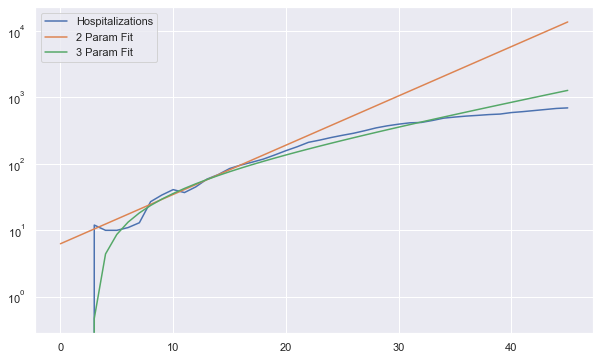

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
fit_func = func_exp
t = df.set_index('date').loc['2020-03-19':'2020-03-26']
popt, pcov = curve_fit(fit_func, t.day, t.hosp, p0=fit_func.popt)
ax.plot(df.day, df.hosp, label='Hospitalizations')
ax.plot(df.day, func_exp(df.day,*popt), label='2 Param Fit')
a, b = unc.correlated_values(popt, pcov)
print (a, b, func_exp(x_p, *popt))

fit_func = func_exp_c
popt, pcov = curve_fit(fit_func, t.day, t.hosp, p0=fit_func.popt)

ax.plot(df.day, func_exp_c(df.day,*popt), label='3 Param Fit')

a, b, c = unc.correlated_values(popt, pcov)
py = func_exp_unc(x_p,  *popt)
print(a, b, c, py)

plt.yscale('log')

plt.legend()

nom = unp.nominal_values(py)
std = unp.std_devs(py)

nom, std*1.96



In [16]:
list(popt)

[37.755784253049086, 0.07904844705406641, -47.388921048402814]

In [8]:
# Try a range of dates for the exponential curve fit


dly = 26-19

def gen_dates():
    "Generate a range of dates"
    for start in range(19-1,19+1+1):
        for delay in range(dly-1,dly+1+1):
            end = start + delay
            sd, ed = f'2020-03-{start}', f'2020-03-{end}'
            yield pd.Timestamp(sd), pd.Timestamp(ed)
              
def date_error_anaysis():
    for sd, ed in gen_dates():
        t = df.set_index('date').loc[sd:ed]
        print(sd, ed)
        try:
            popt, pcov = curve_fit(func_exp, t.day, t.hosp)
            popt2, pcov = curve_fit(func_exp_c, t.day, t.hosp, p0=list(popt)+[0], maxfev=10000)
            yield  [sd,ed,func_exp(44, *popt), func_exp_c(44, *popt2)]
        except RuntimeError:
            raise
            continue

rows = list(date_error_anaysis())

2020-03-18 00:00:00 2020-03-24 00:00:00
2020-03-18 00:00:00 2020-03-25 00:00:00
2020-03-18 00:00:00 2020-03-26 00:00:00
2020-03-19 00:00:00 2020-03-25 00:00:00
2020-03-19 00:00:00 2020-03-26 00:00:00
2020-03-19 00:00:00 2020-03-27 00:00:00
2020-03-20 00:00:00 2020-03-26 00:00:00
2020-03-20 00:00:00 2020-03-27 00:00:00
2020-03-20 00:00:00 2020-03-28 00:00:00


In [9]:
r = pd.DataFrame(rows, columns='start_date end_date est2 est3'.split())
r

,start_date,end_date,est2,est3
0,2020-03-18,2020-03-24,14633.158073,234.884017
1,2020-03-18,2020-03-25,16860.746459,252.710177
2,2020-03-18,2020-03-26,15640.274471,703.911177
3,2020-03-19,2020-03-25,10691.197790,251.961475
4,2020-03-19,2020-03-26,11526.610711,1175.936563
5,2020-03-19,2020-03-27,14157.220054,10512.261733
6,2020-03-20,2020-03-26,6374.277594,694275.595373
7,2020-03-20,2020-03-27,9955.907938,363549.653995
8,2020-03-20,2020-03-28,9477.435283,38243.204371


In [10]:
r.describe().loc[('mean','std'),]

,est2,est3
mean,12146.314264,123244.457653
std,3398.535746,244708.831403


# Linear Method


In [11]:
def fit_hosp(df):
    """Do an OLS regression on the hospitalization cases"""
    df = df.copy()
    df['hosp'] = np.log(df.hosp)

    df = df[['day','hosp']]

    df = df.replace([np.inf,-np.inf],np.nan).dropna()

    X_ = df.day.values.reshape(len(df), 1)
    X = sm.add_constant(X_)
    y = df.hosp.values.reshape(len(df), 1)

    model = sm.OLS(y, X)
    res = model.fit()
    
    return X_, X, y, df, res
    

/Users/eric/opt/anaconda3/envs/data/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/eric/opt/anaconda3/envs/data/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     57.71
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000127
Time:                        09:32:34   Log-Likelihood:                 3.0368
No. Observations:                   9   AIC:                            -2.074
Df Residuals:                       7   BIC:                            -1.679
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5848      0.286      5.549      0.0

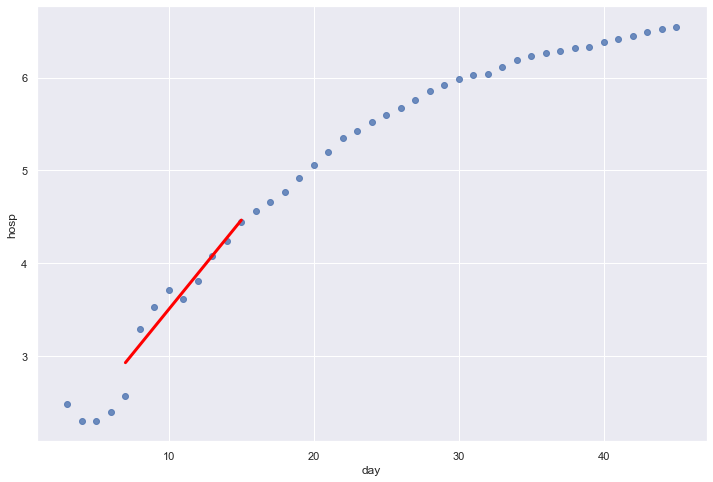

In [22]:

fig, ax = plt.subplots(figsize=(12,8))

t = df.set_index('date').loc['2020-03-19':'2020-03-27']

X_, X, y, t, res = fit_hosp(t)

t = df.set_index('date')
t['hosp'] = np.log(t.hosp)
sns.regplot(ax=ax, x='day',y='hosp', data=t, label = 'Growth rate')

ax.plot(X_, res.predict(), color='red', linewidth=3)
    
print(res.summary())



In [40]:
pd.Series((list(y.flat) - res.predict())/ res.predict()).describe()

count    9.000000
mean    -0.000406
std      0.058494
min     -0.124257
25%     -0.021165
50%     -0.005011
75%      0.056053
max      0.064427
dtype: float64

/Users/eric/opt/anaconda3/envs/data/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


count         9.000000
mean      38106.414395
std       38160.450192
min        4810.285846
25%        7298.568492
50%       24751.546884
75%       50518.249473
max      119815.641847
Name: mean, dtype: float64

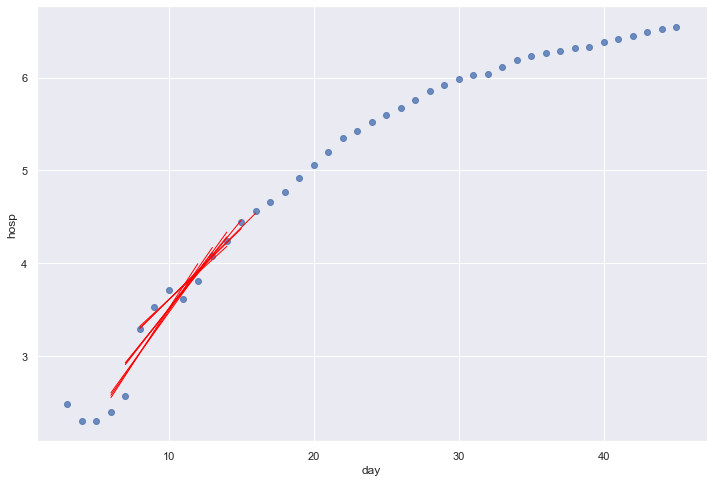

In [13]:
def ols_range_95(res):
    """Return the 95% confidence interval and the mean"""
    
    b_95 = res.conf_int()[0]
    m_95 = res.conf_int()[1]

    b = res.params[0]
    m = res.params[1]

    return np.exp(m_95[0]*x_p+b_95[0]), np.exp(m*x_p+b),  np.exp(m_95[1]*x_p+b_95[1])

fig, ax = plt.subplots(figsize=(12,8))

sns.regplot(ax=ax, x=df.day,y=np.log(df.hosp), data=df, label = 'Growth rate')

rows = []

for sd, ed in gen_dates():
    t = df.set_index('date').loc[sd:ed].copy()
    X_, X, y, t, res = fit_hosp(t)

    t['hosp'] = np.log(t.hosp)

    ax.plot(X_, res.predict(), color='red', linewidth=1)

    rows.append( (sd, ed) + ols_range_95(res))

lin = pd.DataFrame(rows, columns = 'start end l95 mean u95'.split())
lin['mean'].describe()


In [14]:
lin

,start,end,l95,mean,u95
0,2020-03-18,2020-03-24,6.378142e-24,119815.641847,2.250779e+33
1,2020-03-18,2020-03-25,2.735314e-18,74477.300040,2.027872e+27
2,2020-03-18,2020-03-26,1.296654e-14,50518.249473,1.968214e+23
3,2020-03-19,2020-03-25,3.925136e-27,31795.708590,2.575623e+35
4,2020-03-19,2020-03-26,9.870045e-21,24751.546884,6.207054e+28
5,2020-03-19,2020-03-27,1.505472e-16,22777.724944,3.446259e+24
6,2020-03-20,2020-03-26,1.102759e-30,4810.285846,2.098270e+37
7,2020-03-20,2020-03-27,2.135234e-23,6712.703435,2.110326e+30
8,2020-03-20,2020-03-28,1.173355e-18,7298.568492,4.539895e+25


TypeError: func_exp() takes 3 positional arguments but 4 were given

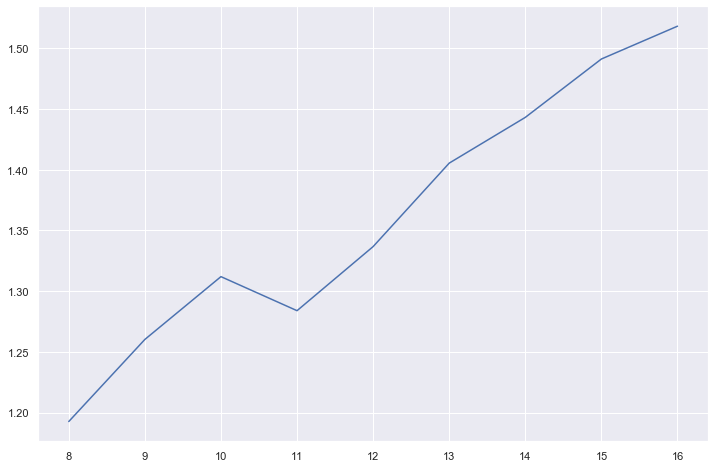

In [15]:
fig, ax = plt.subplots(figsize=(12,8))

nom = unp.nominal_values(py)
std = unp.std_devs(py)

ax.plot(t.day, t.hosp)
ax.plot(t.day, func_exp(t.day,*popt))

# Curve Fits with Error



In [221]:
## Fit to hospitalizations to get parameters and relative error

start_date = pd.Timestamp('2020-03-16')
end_date = pd.Timestamp('2020-03-26')

fit_func = func_exp_c

t = df.set_index('date').loc[start_date:end_date]
popt, pcov = curve_fit(fit_func, t.day, t.hosp, p0=fit_func.popt)

y_p = fit_func(t.day,*popt) # Supposing that the curve fit is the true curve
err_std = ( ( y_p - t.hosp)  / y_p).std() # relative error

# Parameters for the base curve, the "true" values that we'll add error to. 
# Doesn't really matter what it is exactly, but should be similar to reality

curve_params = list(popt) + ([0]*(3-len(popt))) # Ensure there are always three components to the params

curve_params, err_std


([17.87786788068663, 0.11442405543990253, -21.0461620818897], 0.20153800678147)

In [222]:
# Shift from working with actual dates, to an undated series of values. 
start_day = (start_date - df.date.min()).days
end_day = (end_date - df.date.min()).days

cp = curve_params[:]
#cp[0] = 0


def func_exp(x, a, b):
    '''Exponential curve, with no constant'''
    return a * np.exp(b * x) 
func_exp.popt = curve_params[:2]

def func_exp_c(x, a, b, c):
    """Version of func_exp with a constant"""
    return a * np.exp(b * x) +c 
func_exp_c.popt = curve_params

def bootff(fit_func, start_day=start_day, end_day=end_day, err_std=err_std, curve_params=curve_params, iters=1000):

    # The two fit functions require different lengths of parameters
    ff_cp = curve_params[:len(fit_func.popt)]

    # Range of data that we'll fit to
    x_f = np.linspace(start_day, end_day) 
    y_f = fit_func(x,  *ff_cp)

    diff = None
    
    for i in range(iters):
        
        # Optimize zero error case
        if diff is not None and err_std == 0:
            yield diff
            continue
        
        # Add some noise
        y_noise = np.random.normal(0, err_std, size=x.size)
        y_e = y*(1+y_noise)

        popt, pcov = curve_fit(fit_func, x_f, y_e, p0=fit_func.popt, maxfev = 5000)

        # Take the difference between the predictions at day 60
        diff = fit_func(60, *ff_cp) - fit_func(60, *popt)
        yield diff


trials = pd.DataFrame({
    'exp2': list(bootff(func_exp, curve_params=cp)),
    'exp2_ze': list(bootff(func_exp, curve_params=cp, err_std=0)),
    'exp3': list(bootff(func_exp_c, curve_params=cp)),
    'exp3_ze': list(bootff(func_exp_c, curve_params=cp, err_std=0)),
})

trials.describe()

,exp2,exp2_ze,exp3,exp3_ze
count,1000.000000,1000.000000,1.000000e+03,1000.000000
mean,-3112.371156,443.005552,-1.007652e+06,15707.938121
std,12120.949438,0.000000,1.675145e+07,0.000000
min,-76073.854989,443.005552,-3.635005e+08,15707.938121
25%,-8153.957650,443.005552,9.280668e+03,15707.938121
50%,-33.737959,443.005552,1.588642e+04,15707.938121
75%,5074.278369,443.005552,1.673492e+04,15707.938121
max,14417.628985,443.005552,1.691026e+04,15707.938121


In [199]:
trials.sort_values('exp3')

,exp2,exp2_ze,exp3,exp3_ze,exp3ln
26,-183824.768693,-171068.955452,-6.694138e+08,-1.455192e-11,NaN
586,-156850.821587,-171068.955452,-1.195419e+08,-1.455192e-11,NaN
63,-212535.200626,-171068.955452,-1.003943e+08,-1.455192e-11,NaN
640,-28561.898390,-171068.955452,-9.415556e+07,-1.455192e-11,NaN
22,-163218.986663,-171068.955452,-6.925783e+07,-1.455192e-11,NaN
...,...,...,...,...,...
605,-190722.838778,-171068.955452,3.961033e+03,-1.455192e-11,8.284260
852,-84343.181002,-171068.955452,3.962121e+03,-1.455192e-11,8.284535
95,-65444.558316,-171068.955452,3.965268e+03,-1.455192e-11,8.285329
13,-95217.915909,-171068.955452,3.967082e+03,-1.455192e-11,8.285786
